<h1 style="text-align: center;">Final Project</h1>
<h2 style="text-align: center;">02807 Computational Tools for Data Science</h2>
<p style="text-align: center;">Authors: s241645, s242689, s253167, s253095</p>

In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pathlib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path
import os
from typing import List, Tuple, Union
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import MiniBatchKMeans
from collections import namedtuple
from sklearn.preprocessing import StandardScaler, RobustScaler


In [244]:
# Read in the dataset 

df = pd.read_csv('../data/base_data.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [131]:
# We must scale the data 

# df = df.drop(df[df['Class'] == 1].index)
# df = df.drop(columns=['Class'])

# scaler = StandardScaler().fit(df)
# scaled_features = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# only keep the non-fraudulent transactions
df = df[df['Class'] == 0]

X = df.drop(columns=['Class'])

scaler = StandardScaler().fit(X)
scaled_features = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



In [132]:
scaled_features.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.997311,-0.709318,-0.040897,1.729278,0.990318,-0.253111,0.345814,0.194961,0.085847,0.329935,...,0.327804,-0.023799,0.383938,-0.177821,0.110203,0.246918,-0.392003,0.334882,-0.063495,0.244978
1,-1.997311,0.613447,0.166369,0.105514,0.325789,0.040539,-0.063890,-0.075118,0.074140,-0.238563,...,-0.089088,-0.313315,-0.882458,0.162544,-0.561392,0.321113,0.261211,-0.021693,0.045390,-0.342022
2,-1.997290,-0.708564,-0.815934,1.206398,0.276933,-0.374656,1.352205,0.663069,0.214129,-1.394661,...,0.683654,0.347822,1.066308,1.461439,-1.138317,-0.629228,-0.288283,-0.137690,-0.181273,1.160016
3,-1.997290,-0.505312,-0.109660,1.219954,-0.611299,-0.011305,0.936072,0.193273,0.325863,-1.277484,...,-0.269837,-0.149382,0.007320,-0.306158,-1.941201,1.243401,-0.460047,0.157683,0.187621,0.140626
4,-1.997269,-0.604823,0.540370,1.052583,0.293549,-0.303883,0.070195,0.494678,-0.232090,0.746708,...,0.532195,-0.011412,1.103061,-0.221192,0.232939,-0.395620,1.041722,0.549676,0.655384,-0.073152


In [135]:
# Our implementation of the K-means clustering algorithm.

def kmeans_implementation(df, k, max_iters=300, tol=0.0001, random_state=42):

    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    data = df.to_numpy()
    n_samples, n_features = data.shape

    # Randomly choose initial centroids
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = data[indices, :]

    for iteration in range(max_iters):
        # Assign points to nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            points = data[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                # Reinitialize empty cluster randomly
                new_centroids[i] = data[np.random.randint(0, n_samples)]

        # Check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

Converged after 21 iterations.
k=2, DB score=3.9074
Converged after 26 iterations.
k=3, DB score=3.2911
Converged after 29 iterations.
k=4, DB score=3.1648
Converged after 43 iterations.
k=5, DB score=2.8002
Converged after 33 iterations.
k=6, DB score=2.6277
Converged after 37 iterations.
k=7, DB score=2.8928
Converged after 37 iterations.
k=8, DB score=2.9295
Converged after 39 iterations.
k=9, DB score=2.7814
Converged after 41 iterations.
k=10, DB score=2.6526


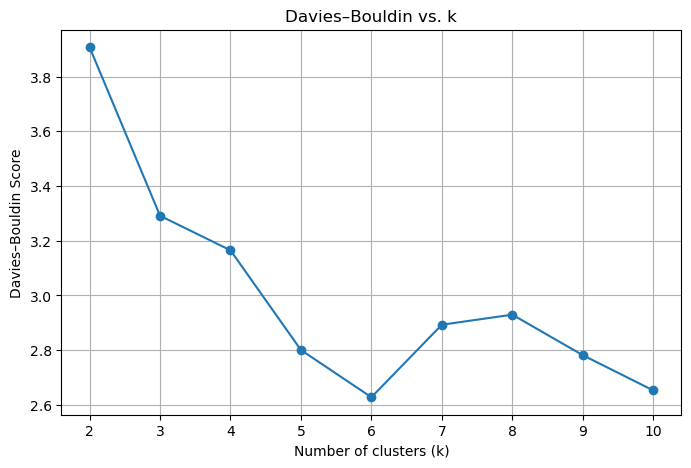

In [136]:
# Let's look at the Davies-Bouldin index for a few values of k

db_scores = []
k_values = list(range(2, 11))

for k in k_values:
    labels, centroids = kmeans_implementation(scaled_features,k)
    db = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db)
    print(f"k={k}, DB score={db:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Score")
plt.title("Davies–Bouldin vs. k")
plt.grid(True)
plt.show()

Converged after 21 iterations.
k=2, inertia=8071074.4186495645
Converged after 26 iterations.
k=3, inertia=7782362.811773296
Converged after 29 iterations.
k=4, inertia=7590063.391485748
Converged after 43 iterations.
k=5, inertia=7315341.544271263
Converged after 33 iterations.
k=6, inertia=7110181.687775589
Converged after 37 iterations.
k=7, inertia=7079146.161756423
Converged after 37 iterations.
k=8, inertia=6943107.990430953
Converged after 39 iterations.
k=9, inertia=6757144.808367376
Converged after 41 iterations.
k=10, inertia=6584641.385517689


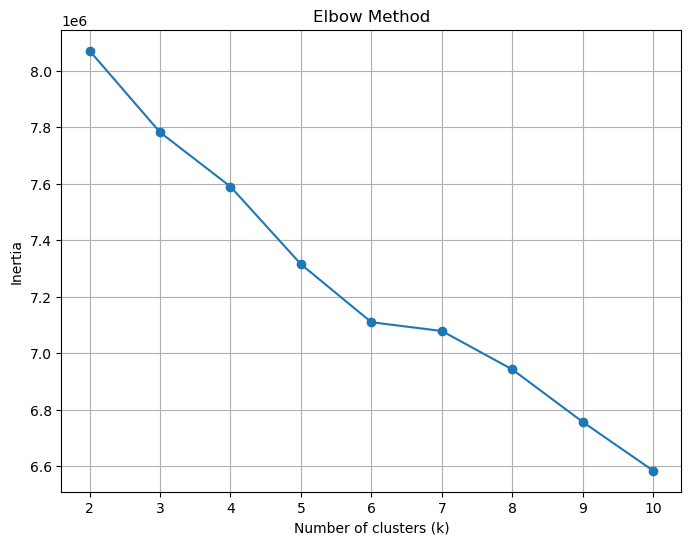

In [137]:
# Let's plot the elbow method to find the optimal k

def compute_inertia(df, labels, centroids):
    inertia = 0.0
    for i, p in enumerate(df.to_numpy()):
        c = centroids[labels[i]]
        inertia += np.sum((p - c) ** 2)
    return inertia

inertia_values = []
k_values = range(2, 11)   

for k in k_values:
    labels, centroids = kmeans_implementation(scaled_features, k)   
    inertia = compute_inertia(scaled_features, labels, centroids)
    inertia_values.append(inertia)
    print(f"k={k}, inertia={inertia}")

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [143]:
# Let's do the same using sklearn's KMeans

# db_scores_sk = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k,random_state=42, n_init=10)
#     labels_sklearn = kmeans.fit_predict(scaled_features)
#     db = davies_bouldin_score(scaled_features, labels_sklearn)
#     db_scores_sk.append(db)
#     print(f"k={k}, DB score={db:.4f}")

# # Plot results
# plt.figure(figsize=(8, 5))
# plt.plot(k_values, db_scores_sk, marker='o')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Davies–Bouldin Score")
# plt.title("Davies–Bouldin Score vs. k (sklearn)")
# plt.grid(True)
# plt.show()

In [ ]:
# Elbow method using sklearn's KMeans

# inertia_values = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(scaled_features)
#     inertia_values.append(kmeans.inertia_)
#     print(f"k={k}, inertia={kmeans.inertia_:.2f}")

# plt.figure(figsize=(8, 5))
# plt.plot(k_values, inertia_values, marker='o')
# plt.xlabel("Number of clusters (k)")
# plt.ylabel("Inertia")
# plt.title("Elbow Method (sklearn)")
# plt.grid(True)
# plt.show()

Converged after 29 iterations.


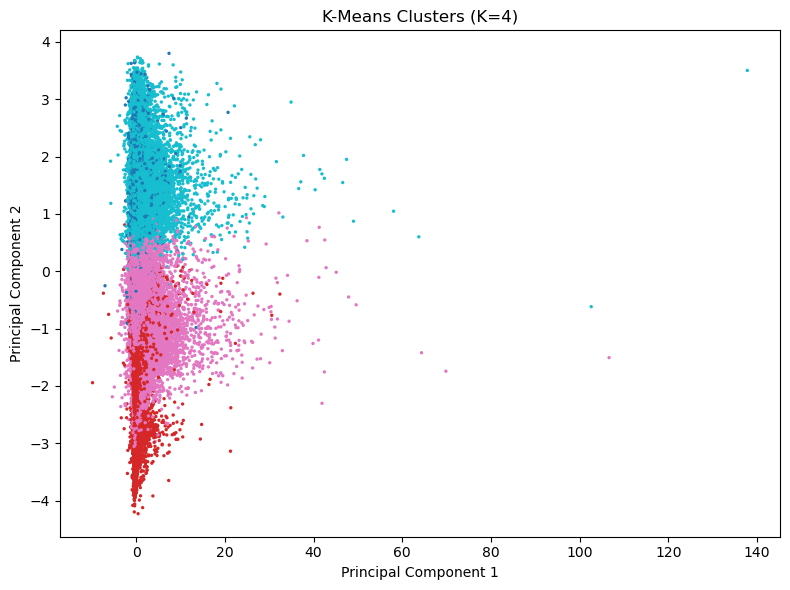

In [344]:
# Visualize the clusters using PCA

labels, centroids = kmeans_implementation(scaled_features, k=4)

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=2)
plt.title("K-Means Clusters (K=4)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()



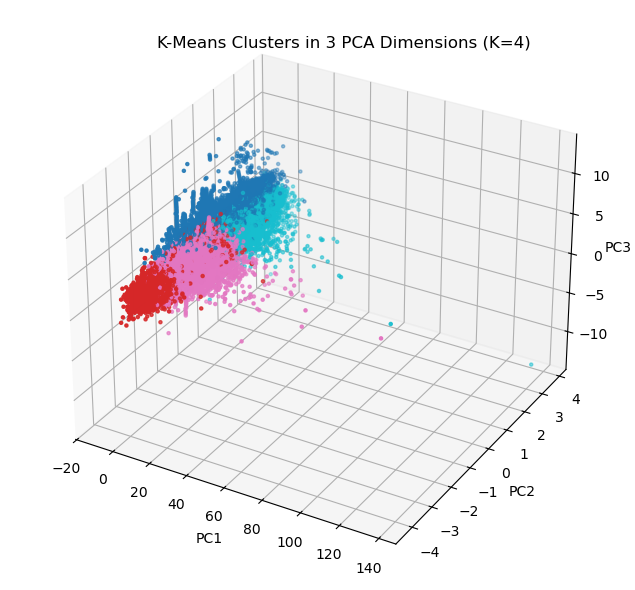

In [341]:
# Let's try it in 3D

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  


pca = PCA(n_components=3)
reduced = pca.fit_transform(scaled_features)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    reduced[:, 0], 
    reduced[:, 1], 
    reduced[:, 2],
    c=labels,
    cmap='tab10',
    s=5
)
ax.set_title("                            K-Means Clusters in 3 PCA Dimensions (K=4)                  ", y=1)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3", labelpad=0)
plt.tight_layout()
#fig.subplots_adjust(right=0.43)
plt.show()

In [345]:
# Print percentage of points in each cluster

unique, counts = np.unique(labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
total_points = len(labels)
for cluster, count in cluster_distribution.items():
    percentage = (count / total_points) * 100
    print(f"Cluster {cluster}: {count} points ({percentage:.2f}%)")

Cluster 0: 33591 points (11.90%)
Cluster 1: 19755 points (7.00%)
Cluster 2: 137615 points (48.74%)
Cluster 3: 91386 points (32.37%)


In [159]:
# Print percentage of points in each cluster for sklearn implementation
kmeans = KMeans(n_clusters=4, random_state=0)
labels_sklearn = kmeans.fit_predict(scaled_features)
unique_sk, counts_sk = np.unique(labels_sklearn, return_counts=True)
cluster_distribution_sk = dict(zip(unique_sk, counts_sk))
total_points_sk = len(labels_sklearn)
for cluster, count in cluster_distribution_sk.items():
    percentage = (count / total_points_sk) * 100
    print(f"Cluster {cluster}: {count} points ({percentage:.2f}%)")

Cluster 0: 20063 points (7.11%)
Cluster 1: 120519 points (42.68%)
Cluster 2: 38083 points (13.49%)
Cluster 3: 103682 points (36.72%)
